## CLASSIFICATION of SPEECH FRAMES

### PART IV:  Recognize Vowels from FBANK features using DNN Classifiers in PyTorch

### 1. Setting up your Python Environment
 
+ Import Python's Machine Learning Stack
+ Import needed local utilities that are needed for this exercise
+ Import Pytorch

In [2]:
%matplotlib inline
import sys,os,io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as sio
import urllib.request

# imports from the scikit-learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Perceptron
from sklearn import metrics as skmetrics
from sklearn.mixture import GaussianMixture
from scipy.fftpack import dct

# import pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

try:
  import google.colab
  IN_COLAB = True
  ! pip install git+https://github.c
except:
  IN_COLAB = False

from pyspch.core.hillenbrand import fetch_hillenbrand, select_hillenbrand


In [3]:
# choose the colors you like :)
palette = sns.color_palette("bright")
# palette=['red','green','blue','orange','brown','black','dodgerblue','mediumturquoise','cyan','violet','gold','salmon'] 
# sns.palplot(palette)
sns.set_palette(palette)

### 2. The Database 
The experiments in this notebook use a subset of the TIMIT database.
Instead of using raw speech, we extract features from the speech signal.
In what follows we will asses how 
There is FILTERBANK data from 3 vowels (i,a,uw) , 400 samples for training and 200 samples for testing.
The data is 24-dimensional (24 channels in the filterbank).
http://homes.esat.kuleuven.be/~spchlab/datasets/tinytimit/README.txt

The loaded data consists of:
- data matrices   FBANK_train(2400,3), FBANK_test(600,3)
- labels          y_train(2400,), y_test(600,)

In [4]:
# loads all data in a matlab file at given url to the contents structure
# this is working for MATLAB 7.0 files and older ; not hdf5 MATLAB 7.3 or more recent
def load_matlab_from_url(url):
    url_response = urllib.request.urlopen(url)
    matio = io.BytesIO(url_response.read())
    contents = sio.loadmat(matio,squeeze_me=True)
    return(contents)

# we will import 400 train samples and 200 test samples for 3 vowels
tinytimit = 'http://homes.esat.kuleuven.be/~spchlab/datasets/tinytimit/'
url_mf = tinytimit + 'male-female.mat' 
data_mf = load_matlab_from_url(url_mf)
url_vow3= tinytimit + 'a-i-uw-800.mat' 
data_vow3 = load_matlab_from_url(url_vow3)

# labels
y_train =np.full((2400,),'a',dtype='<U2')
y_train[800:1600] =np.full((800,),'i',dtype='<U2')
y_train[1600:2400] =np.full((800,),'uw',dtype='<U2')
y_test =np.full((600,),'a',dtype='<U2')
y_test[200:400] =np.full((200,),'i',dtype='<U2')
y_test[400:600] =np.full((200,),'uw',dtype='<U2')
classes = np.unique(y_train)

#### Feature Extraction

For our NN-based phoneme-classifier, we can choose between three types of input features.  First, we have the filterbank energies (FBANK) directly. Second, we can use the PCA features derrived from the FBANK features. Alternatively MFCC features can be derived from the FBANK features.

In [5]:
# A. Filterbank Energies (spectral features)
FB_train=data_vow3['ALLtrain'].T
FB_test=data_vow3['ALLtest'].T

# B. PCA features (Principle Component Analysis)
from sklearn.decomposition import PCA
pca = PCA()
T = pca.fit(FB_train)
PCA_train = T.transform(FB_train)
PCA_test = T.transform(FB_test)

# C. Mel-Frequency Cepstral Coefficients
MFCC_train = dct(FB_train, type=2, axis=1, norm='ortho')
MFCC_test = dct(FB_test, type=2, axis=1, norm='ortho')

#### Feature visualization

In [6]:
# Define a number of different Features

# A. Filterbank Energies (spectral features)
dfX = pd.DataFrame(FB_train[:,0:4])
dfy = pd.Series(y_train, name='vowel')
FB_df = pd.concat([dfy, dfX], axis=1)

# B. PCA features (Principle Component Analysis)
dfX = pd.DataFrame(PCA_train[:,0:4])
dfy = pd.Series(y_train, name='vowel')
PCA_df = pd.concat([dfy, dfX], axis=1)

# C. Mel-Frequency Cepstral Coefficients
dfX = pd.DataFrame(MFCC_train[:,0:4])
dfy = pd.Series(y_train, name='vowel')
MFCC_df = pd.concat([dfy, dfX], axis=1)

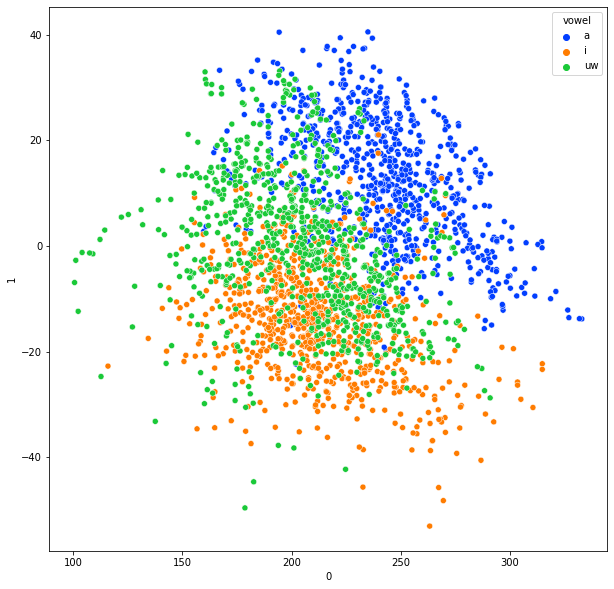

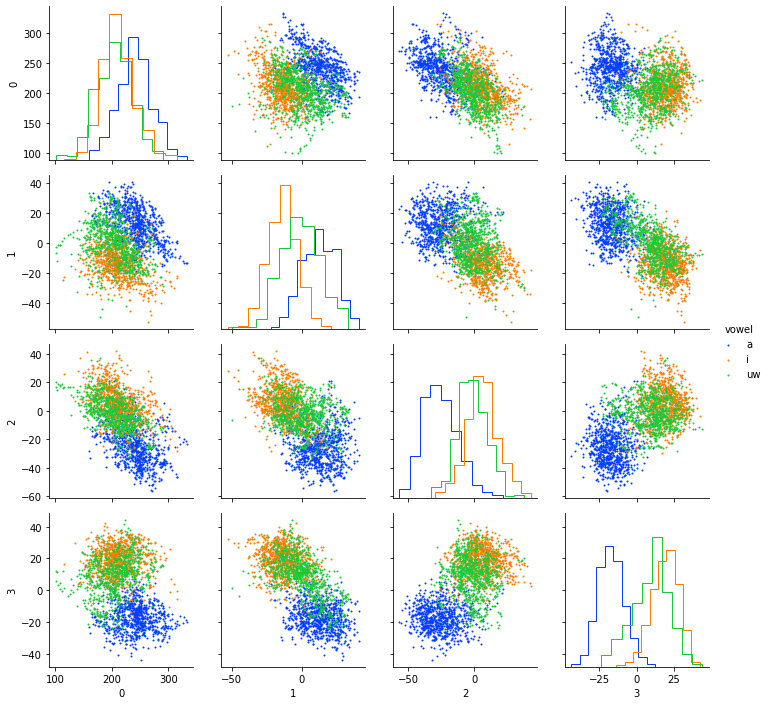

In [7]:
# choose feature set to use in plots and experiments
df = MFCC_df
df.columns = ["vowel","0","1","2","3"]

doPlot = True
if doPlot:
  # plot 2 first dimensions of feature 
  f=plt.figure(figsize=(10, 10))
  sns.scatterplot(data=df, x="0", y="1", hue='vowel')

  # plot all dimensions pairwise
  g = sns.PairGrid(df, hue="vowel")
  g.map_diag(plt.hist, histtype="step", linewidth=1)
  g.map_offdiag(plt.scatter, s=1)
  g.add_legend()

### 3. Setting up a Neural Network in Pytorch

Quite a few helper routines are defined for learning our Neural Network in Pytorch.
There is no need to go through this in detail, but interested people can of course do this.

There are 3 blocks of code:
- definition of classes for the Neural Net and the Data Sets
- training routines
- evalutation routines

In [8]:
# =============================================================================
# Define Classes for Neural network architecture and Data Sets
# =============================================================================

# simple feedforward neural network 
class simple_ffnn(nn.Module):
    
    def __init__(self, in_dim, out_dim, hidden_layer_sizes):
        super(simple_ffnn, self).__init__()

        # attributes
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_layer_sizes = hidden_layer_sizes

        # parameters
        layer_sizes = (in_dim, *hidden_layer_sizes, out_dim)
        layer_sizes_pairwise = [(layer_sizes[i], layer_sizes[i+1]) for 
                                 i in range(len(layer_sizes)-1)]

        # define architecture
        modulelist = nn.ModuleList([])
        for layer_in_size, layer_out_size in layer_sizes_pairwise:
            modulelist.append(nn.Linear(layer_in_size, layer_out_size))
            modulelist.append(nn.Sigmoid())

        # define network as nn.Sequential
        self.net = nn.Sequential(*modulelist)

    def forward(self, x):
        x = self.net(x)
        return x
        
    def init_weights(self):
        self.net.apply(init_normal) 

def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_uniform_(m.weight)   
        
# Dataset 
class SimpleDataset(Dataset):
    """Simple dataset for easy sampling."""

    def __init__(self, data_X, data_y, labels, labeldict, device):

        # dimensionality
        self.n_samples, self.n_features = data_X.shape
        self.n_classes = len(labels)

        # input data
        self.frames = data_X # (n_samples, n_features)
        self.frames = torch.as_tensor(self.frames, dtype=torch.float32).to(device)

        # labels
        if data_y.dtype != "int64":
            data_y = np.vectorize(labeldict.get)(data_y)
        self.labels = torch.as_tensor(data_y, dtype=torch.long).to(device)

    def __len__(self):
        
        return self.n_samples

    def __getitem__(self, idx):
        frame = self.frames[idx] 
        label = self.labels[idx]
        
        return frame, label

In [9]:
# =============================================================================
# Neural network training routines
# =============================================================================

# simple batch gradient descent 
def train_batch(network, train_X, train_y, criterion, optimizer,
                device, n_epochs=500, every=50):

    # data-format is torch tensor + send to device (ex. GPU)
    train_X = torch.tensor(train_X, dtype=torch.float32).to(device)
    train_y = torch.tensor(train_y, dtype=torch.long).to(device)

    # send network to device (ex. GPU)
    network.to(device)

    # set network to training mode (vs. evaluation mode)
    network.train() 

    # save training loss
    train_loss = []

    # train for some epochs - full batch
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = network(train_X)
        loss = criterion(output, train_y)
        loss.backward()
        optimizer.step()
        if epoch%every == 0:
          print('Epoch {}, loss {}'.format(epoch, loss.item()))
        
        train_loss.append(loss.item())
      
    return train_loss

# mini-batch gradient descent
def train_minibatch(network, train_dl, criterion, optimizer, device,
                    n_epochs=500, every=50):
    """
    Makes use of torch dataloader (see later on) to split data into mini-batches
    """ 

    #  per epoch: update network parameters 
    for epoch in range(n_epochs):

        # network to training mode
        network.train()
        
        # save training loss
        train_loss = []

        # per mini-batch: compute gradient (backpropagation) + take step 
        running_loss = 0
        steps = 0 
        for i, data in enumerate(train_dl, 0):

            # mini-batch inputs and labels
            frames, labels = data  
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize 
            outputs = network.net(frames)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()  

            # running loss
            running_loss += loss.item()

        mean_minibatch_loss = running_loss/len(train_dl)
        train_loss.append(mean_minibatch_loss)

        if epoch%every == 0:   
          print("Epoch %d -- av. loss per mini-batch %.2f" % (epoch, mean_minibatch_loss))

    return train_loss
            
# mini-batch gradient descent with early stopping
def train_minibatch_earlystopping(network, train_dl, criterion, optimizer, device,
                                  n_epochs=500, valid_X=None, valid_y=None, patience=5,
                                  every=50):
    """
    Makes use of torch dataloader (see later on) to split data into mini-batches
    """ 

    # set early stopping counter
    cnt_valid_loss_increase = 0

    # data-format is torch tensor + send to device (ex. GPU)
    valid_X = torch.tensor(valid_X, dtype=torch.float32).to(device)
    valid_y = torch.tensor(valid_y, dtype=torch.long).to(device)

    # save training and validation loss
    train_loss_list = []
    valid_loss_list = []

    #  per epoch: update network parameters 
    for epoch in range(n_epochs):

        # network to training mode
        network.train()
        
        # early stopping 
        earlystoppping = cnt_valid_loss_increase > patience
        if earlystoppping:
            print("stopped early after %d epochs" % (epoch))
            return train_loss_list, valid_loss_list

        # per mini-batch: compute gradient (backpropagation) + take step 
        running_loss = 0
        steps = 0 
        for i, data in enumerate(train_dl, 0):

            # mini-batch inputs and labels
            frames, labels = data  
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize 
            outputs = network.net(frames)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()  

            # running loss
            running_loss += loss.item()

        # training loss
        mean_minibatch_loss = running_loss/len(train_dl)
        train_loss_list.append(mean_minibatch_loss)
        if epoch%every == 0:   
            print("Epoch %d -- av. loss per mini-batch %.2f" % (epoch, mean_minibatch_loss))

        # validation loss
        if valid_X is not None and valid_y is not None:          
            valid_outputs = network.net(valid_X)
            valid_loss = criterion(valid_outputs, valid_y)
            valid_loss_list.append(valid_loss.item())
            
            # early stoppping
            loss_increase = valid_loss_list[-1] > min(valid_loss_list[-patience:])
            if loss_increase:
                # no improvement compared to last 'patience' steps
                cnt_valid_loss_increase += 1
            else:
                cnt_valid_loss_increase = 0

    return train_loss_list, valid_loss_list

In [10]:
# =============================================================================
# Neural network evaluation routines
# =============================================================================

# evaluate criterion
def evaluate_criterion(network, test_X, test_y, criterion, device):
    
    # data-format is torch tensor + send to device (ex. GPU)
    test_X = torch.tensor(test_X, dtype=torch.float32).to(device)
    test_y = torch.tensor(test_y, dtype=torch.long).to(device)

    # send network to device (ex. GPU)
    network.to(device)

    # set network to evaluation mode (vs. training mode)
    network.eval() 

    # compute loss based on criterion
    pred_y = network.net(test_X)
    loss = criterion(pred_y, test_y)

    return loss.item()

# evaluate confusion matrix
def confusionmatrix(network, test_X, test_y, device):
    
    # data-format is torch tensor + send to device (ex. GPU)
    test_X = torch.tensor(test_X, dtype=torch.float32).to(device)
    test_y = torch.tensor(test_y, dtype=torch.long).to(device)

    # send network to device (ex. GPU)
    network.to(device)

    # set network to evaluation mode (vs. training mode)
    network.eval() 

    # compute confusion matrix
    cm = np.zeros((network.out_dim,network.out_dim))
    for input, label in zip(test_X, test_y):
        prob = network.net(input) # output = posterior class probabilities
        pred = torch.argmax(prob) # prediction = label (or neuron) with highest probability (One-Hot Encoding)
        cm[label][pred] += 1
    
    return cm.astype(int)

# evaluate phone error rate
def evaluate_PER(confusionmatrix):

    n_classes = confusionmatrix.shape[0]    
    
    # compute ER 
    trace = np.trace(confusionmatrix)
    ER = 1- trace.sum() / confusionmatrix.sum()
        
    # compute ER per class (disregarding non label or not)
    no_examples_pc = confusionmatrix.sum(axis=1)
    ER_pc = [None] * n_classes
    for i in range(n_classes):
        if no_examples_pc[i] != 0:
            ER_pc[i] = 1-confusionmatrix[i,i] / (no_examples_pc[i])
        
    return ER, ER_pc

# =============================================================================
# Confusion matrix plot
# =============================================================================
# Pretty Print routine makes for confusion matrices
def plot_confusion_matrix(cf_mat,labels=[],cmap='Blues'):
    f,ax = plt.subplots()
    sns.heatmap(cf_mat, annot=True,fmt="d",square=True,
                annot_kws={"fontsize": 14},xticklabels=labels,yticklabels=labels,
                linecolor='k',linewidth=1.5,cmap=cmap,cbar=False)
    ax.tick_params(axis='y',labelrotation=0.0,left=True)
    plt.title('Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

### 4. Experimental setup

- Choose the feature extraction
- Define Network Architecture

In [11]:
# Features (X) and labels (y) used for experiment

# input data
train_X = MFCC_train
test_X = MFCC_test

# define One-Hot Encoding for labels
labels = ["a", "i", "uw"]
labeldict = {"a" : 0, "i" : 1, "uw" : 2} 
inv_labeldict = {v : k for k, v in labeldict.items()}

# encode labels
train_y = np.vectorize(labeldict.get)(y_train).astype(np.int64)
test_y = np.vectorize(labeldict.get)(y_test).astype(np.int64)

In [12]:
# network dimensions
in_dim = train_X.shape[1]
out_dim = len(classes)
hidden_layer_sizes = [512,512]

# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Batch gradient descent

Epoch 0, loss 1.0987424850463867
Epoch 50, loss 0.7030432224273682
Epoch 100, loss 0.6416506171226501
Epoch 150, loss 0.6072403192520142
Epoch 200, loss 0.5841529369354248
Epoch 250, loss 0.5727911591529846
Epoch 300, loss 0.5662647485733032
Epoch 350, loss 0.5635660886764526
Epoch 400, loss 0.5619668364524841
Epoch 450, loss 0.560761034488678


Text(0.5, 1.0, 'Training loss - batch gradient descent')

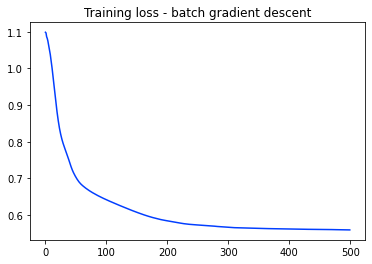

In [13]:
# batch gradient descent
batch_model = simple_ffnn(in_dim=in_dim, out_dim=out_dim, hidden_layer_sizes=hidden_layer_sizes).to(device)

# training setup
n_epochs = 500
batch_lrn_rate = 0.001
batch_criterion = nn.CrossEntropyLoss()  # applies softmax()
batch_optimizer = torch.optim.Adam(batch_model.parameters(), lr=batch_lrn_rate) # ties model-parameters to optimizer (back-propagation)

# train network
batch_train_loss= train_batch(batch_model, train_X, train_y, batch_criterion, batch_optimizer, device, n_epochs)

# plot training loss
plt.figure()
plt.plot(batch_train_loss)
plt.title("Training loss - batch gradient descent")

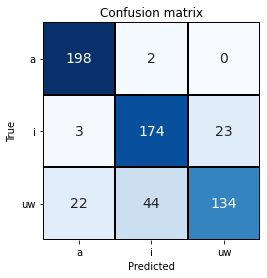

PER 0.16 and PER per phone class [0.01 0.13 0.33]
CEL 0.71


In [15]:
# Confusion matrix
cm = confusionmatrix(batch_model, test_X, test_y, device) #.to(device)
plot_confusion_matrix(cm, classes)

# Phone Error Rate (PER) + PER per phone class
per, per_pc = evaluate_PER(cm)
print("PER %.2f and PER per phone class %s" % (per, np.round(per_pc, 4)))

# Cross-entropy loss
print("CEL %.2f" % evaluate_criterion(batch_model, test_X, test_y, batch_criterion, device))

#### Mini-batch gradient descent

In [16]:
# Dataset and Dataloader for easy sampling mini-batches

# construct dataset
train_ds = SimpleDataset(train_X, train_y, labels, labeldict, device)

# construct dataloader
batch_size = 32
shuffle = True
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle, num_workers=0)

Epoch 0 -- av. loss per mini-batch 0.89
Epoch 50 -- av. loss per mini-batch 0.58
Epoch 100 -- av. loss per mini-batch 0.57
Epoch 150 -- av. loss per mini-batch 0.57


Text(0.5, 1.0, 'Training loss - batch gradient descent')

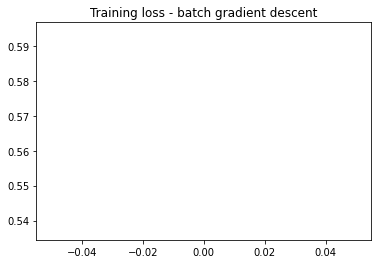

In [17]:
# mini-batch gradient descent
minibatch_model = simple_ffnn(in_dim=in_dim, out_dim=out_dim, hidden_layer_sizes=hidden_layer_sizes).to(device)

# training setup
n_epochs = 200
mb_lrn_rate = 0.001
mb_criterion = nn.CrossEntropyLoss()  # applies softmax()
mb_optimizer = torch.optim.Adam(minibatch_model.parameters(), lr=mb_lrn_rate) # ties model-parameters to optimizer (back-propagation)

# train network
mb_train_loss = train_minibatch(minibatch_model, train_dl, mb_criterion, mb_optimizer, device, n_epochs)

# plot training loss
plt.figure()
plt.plot(mb_train_loss)
plt.title("Training loss - batch gradient descent")


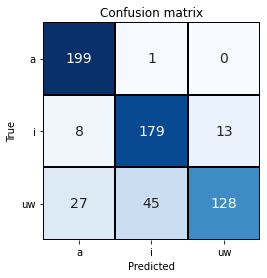

PER 0.16 and PER per phone class [0.005 0.105 0.36 ]
CEL 0.70


In [18]:
# Confusion matrix
cm = confusionmatrix(minibatch_model, test_X, test_y, device)
plot_confusion_matrix(cm, classes)

# Phone Error Rate (PER) + PER per phone class
per, per_pc = evaluate_PER(cm)
print("PER %.2f and PER per phone class %s" % (per, np.round(per_pc, 4)))

# Cross-entropy loss
print("CEL %.2f" % evaluate_criterion(minibatch_model, test_X, test_y, batch_criterion, device))

#### Mini-batch gradient descent with early stopping

Epoch 0 -- av. loss per mini-batch 1.08
Epoch 50 -- av. loss per mini-batch 0.63
stopped early after 93 epochs


Text(0.5, 1.0, 'Training loss - batch gradient descent')

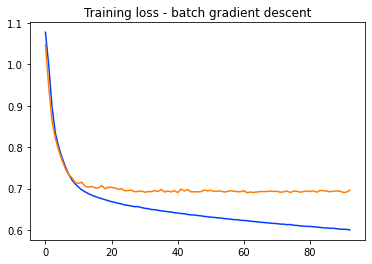

In [19]:
# test training method: mini-batch gradient descent
minibatch_es_model = simple_ffnn(in_dim=in_dim, out_dim=out_dim, hidden_layer_sizes=hidden_layer_sizes).to(device)

# training setup
n_epochs = 200
patience = 30
mb_es_lrn_rate = 0.0001
mb_es_criterion = nn.CrossEntropyLoss()  # applies softmax()
mb_es_optimizer = torch.optim.Adam(minibatch_es_model.parameters(), lr=mb_es_lrn_rate) # ties model-parameters to optimizer (back-propagation)

# train network
mb_es_train_loss, mb_es_valid_loss = train_minibatch_earlystopping(minibatch_es_model, train_dl, mb_es_criterion, mb_es_optimizer, device, n_epochs, test_X, test_y, patience)

# plot training loss
plt.figure()
plt.plot(mb_es_train_loss)
plt.plot(mb_es_valid_loss)
plt.title("Training loss - batch gradient descent")

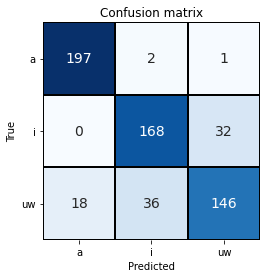

PER 0.15 and PER per phone class [0.015 0.16  0.27 ]
CEL 0.70


In [20]:
# Confusion matrix
cm = confusionmatrix(minibatch_es_model, test_X, test_y, device)
plot_confusion_matrix(cm, classes)

# Phone Error Rate (PER) + PER per phone class
per, per_pc = evaluate_PER(cm)
print("PER %.2f and PER per phone class %s" % (per, np.round(per_pc, 4)))

# Cross-entropy loss
print("CEL %.2f" % evaluate_criterion(minibatch_es_model, test_X, test_y, batch_criterion, device))